In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchtext
from torchtext import data
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import nltk
from nltk.stem.porter import *

import string
import re
import warnings
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")


## Load Data

In [2]:
df=pd.read_csv("data/labeled_data.csv")
df.drop(df.columns[[0]], axis=1,inplace=True)
print(df.iloc[:5,:])
print(df.shape)

   count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
(24783, 6)


In [3]:
# Index of tweet only contain format like"#XX #XX" (which would be empty after remove hashtag)
# We need to specially deal with them
special_index=[804,826,846,848,849,923,1016,1122,1909,3398,4818,5711,6098,6279,6332,6668,7168,11951,15859,18062]
# for example
print(df['tweet'][804])
# Also there are two meaningless tweet
print(df['tweet'][4828])
print(df['tweet'][6098])
meaningless_index=[4828,6098]

#Yankees
@TNKidsFoodPorn @Oreo ..............&#128530;
@hoes &#9829;


In [4]:
#copy original text
txt=df.iloc[:,4:6]
tweet=txt.iloc[:,1].copy(deep=True)
stemmer = PorterStemmer()

In [5]:
tweet[:5]

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

## Data Preprocessing

In [6]:
def preprocess(tweet_,specail_index,meaningless_index):
    #remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    other = ["#ff", "ff", "rt"]
    stopwords.extend(other)
    #word tokenize and remove stopwords
    
    for i in range(tweet_.shape[0]):
        text=tweet_[i].lower()
        text1=''.join([word+" " for word in text.split() if word not in stopwords])
        tweet_[i]=text1
    
    #remove digit and excessive whitespace
    #remove url mention and hashtag
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    
    for i in range(tweet_.shape[0]):
        text_string=tweet_[i]
        parsed_text = re.sub(space_pattern, ' ', text_string)
        parsed_text = re.sub(giant_url_regex, '', parsed_text)
        parsed_text = re.sub(mention_regex, '', parsed_text) 
        if i not in specail_index:
            parsed_text = re.sub(hashtag_regex, '', parsed_text)
        else:
            parsed_text = re.sub('#','',parsed_text)
        if i in meaningless_index:
            parsed_text ='This is a simple tweet'
        tweet_[i]=parsed_text
    
    #tokenize and stemming
    """Removes punctuation and stems tweets. Returns a list of stemmed tokens."""
    for i in range(tweet_.shape[0]):
        
        tweet_stem=tweet_[i]
        
        remove = str.maketrans('','',string.punctuation) 
        tweet_stem = tweet_stem.translate(remove).strip()

        tweet_process = [stemmer.stem(t) for t in tweet_stem.split()]
        
        tweet_[i]=tweet_process
        
        #tweet_[i] = ' '.join([str(elem) for elem in tweet_process]) 
        

        
    return tweet_

#results of pre-process
tweet_temp=preprocess(tweet,special_index,meaningless_index)

In [7]:
all_tweet = tweet_temp.copy()
all_labels = list(df['class'])

In [8]:
tweet_len = []
for t in all_tweet:
    tweet_len.append(len(t))
tweet_len.sort()

In [9]:
np.unique(tweet_len)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 27])

## Dataset creation with torchtext

In [10]:
TEXT = torchtext.data.Field(tokenize=None, batch_first=True, fix_length=15)
LABEL = torchtext.data.LabelField(dtype=torch.float, sequential=False, use_vocab=False)
fields = [('text', TEXT), ('label', LABEL)]

In [11]:
all_example = []
for i in range(len(all_tweet)):
    temp = torchtext.data.Example.fromlist([all_tweet[i], all_labels[i]], fields)
    all_example.append(temp)

In [12]:
total_data = data.Dataset(all_example, fields)

In [13]:
train_data, test_data = total_data.split(split_ratio=0.9)

### Building vocab for embedding

In [14]:
#TEXT.build_vocab(train_data, max_size=10000, vectors='glove.6B.200d')
TEXT.build_vocab(train_data)

In [15]:
print(len(TEXT.vocab)) 
print(TEXT.vocab.itos[:12]) 

15435
['<unk>', '<pad>', 'bitch', 'hoe', 'like', 'fuck', 'pussi', 'im', 'nigga', 'get', 'ass', 'shit']


In [16]:
BATCH_SIZE = 128
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), batch_size=BATCH_SIZE,sort = False)

In [17]:
print(next(iter(train_iterator)).text.shape)
print(next(iter(train_iterator)).label.shape)

torch.Size([128, 15])
torch.Size([128])


## TextCNN model

In [18]:
class TextCNN(nn.Module):   
    def __init__(self, vocab_size, embedding_dim, output_size, filter_num=100, kernel_lst=(1,2,3), dropout=0.5):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                             nn.Sequential(nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                                            nn.ReLU(),
                                            nn.MaxPool2d((SENTENCE_LIMIT_SIZE - kernel + 1, 1)))
                              for kernel in kernel_lst])
        self.fc = nn.Linear(filter_num * len(kernel_lst), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)       #(batch, word_num, embedding_dim)
        x = x.unsqueeze(1)          #[128, 1, 20, 200] 即(batch, channel_num, word_num, embedding_dim)
        out = [conv(x) for conv in self.convs]

        out = torch.cat(out, dim=1)      # [128, 300, 1, 1]
        out = out.view(x.size(0), -1)    #[128, 300]
        out = self.dropout(out)
        logit = self.fc(out)             #[128, 2]

        return logit

In [19]:
LEARNING_RATE = 1e-3      
EMBEDDING_SIZE = 200      
SENTENCE_LIMIT_SIZE = 15

In [20]:
len(TEXT.vocab)

15435

In [21]:
net = TextCNN(len(TEXT.vocab),EMBEDDING_SIZE,3)

In [22]:

def binary_acc(preds, y):

    correct = torch.eq(preds, y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(cnn, iterator, optimizer, criteon):
    avg_acc = []
    cnn.train()        

    for i, batch in enumerate(iterator):
        pred = cnn(batch.text)                         
        loss = criteon(pred, batch.label.long())       

        acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)   
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_acc = np.array(avg_acc)
    return avg_acc




def evaluate(cnn, iterator, criteon):
    avg_acc = []
    cnn.eval()       
    log = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            pred = cnn(batch.text)               #torch.Size([128, 2])
            acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)
            log.append(torch.max(pred, dim=1)[1])
            avg_acc.append(acc)

    avg_acc = np.array(avg_acc)
    return avg_acc, log

Start Training
epoch:0
Elapsed time for epoch: 18.800670862197876 s
Train Accuracy:  [0.40625   0.6953125 0.7734375 0.7734375 0.78125   0.7734375 0.7890625
 0.796875  0.6875    0.7890625 0.8515625 0.7421875 0.7734375 0.78125
 0.75      0.796875  0.8359375 0.8125    0.78125   0.796875  0.8359375
 0.8125    0.8828125 0.8203125 0.734375  0.7578125 0.8125    0.7421875
 0.765625  0.875     0.8046875 0.796875  0.8671875 0.84375   0.8515625
 0.84375   0.8046875 0.84375   0.8359375 0.8515625 0.8125    0.8828125
 0.7890625 0.828125  0.8359375 0.859375  0.78125   0.8203125 0.84375
 0.7890625 0.8671875 0.8359375 0.7890625 0.8671875 0.8671875 0.890625
 0.8515625 0.8515625 0.8359375 0.8984375 0.8359375 0.765625  0.8359375
 0.8515625 0.828125  0.84375   0.828125  0.8671875 0.8046875 0.8671875
 0.8671875 0.84375   0.8203125 0.8984375 0.8984375 0.828125  0.875
 0.8828125 0.8515625 0.8515625 0.8046875 0.8515625 0.875     0.84375
 0.859375  0.828125  0.875     0.8671875 0.8359375 0.828125  0.9375
 0.859

Text(0.5, 1.0, 'Testing accuracy of TextCNN model')

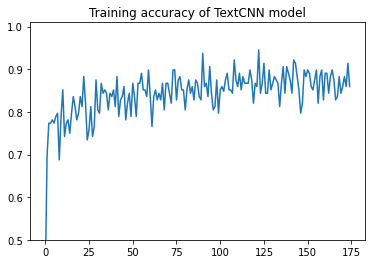

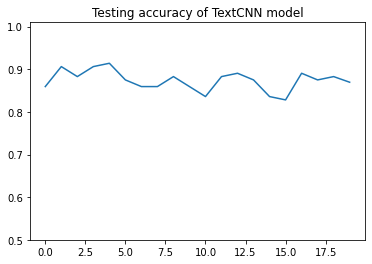

In [23]:
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay = 0.01)
criteon = nn.CrossEntropyLoss()

cnn_train_acc, cnn_test_acc = [], []
print('Start Training')
for epoch in range(1):
    
    time1 = time.time()
    train_acc = train(net, train_iterator, optimizer, criteon)
    
    test_acc, test_log = evaluate(net, test_iterator, criteon)
    time2 = time.time() #timekeeping
    print(f'epoch:{epoch}')
    print('Elapsed time for epoch:',time2 - time1,'s')
    print(f'Train Accuracy:  {train_acc}')
    print(f'Test Accuracy:  {test_acc}')
    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)

plt.figure()
plt.plot(cnn_train_acc[0])
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("Training accuracy of TextCNN model")
plt.figure()
plt.plot(cnn_test_acc[0])
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("Testing accuracy of TextCNN model")

In [24]:
Test_label = []
for i, batch in enumerate(test_iterator):
    Test_label.append(batch.label)

test_pred = test_log[0].clone()
for i in range(1,len(test_log)):
    test_pred = torch.cat([test_pred,test_log[i]], dim = -1)
test_pred = np.array(test_pred)
    
test_label = Test_label[0].clone()
for i in range(1,len(Test_label)):
    test_label = torch.cat([test_label,Test_label[i]], dim = -1)
test_label = np.array(test_label)

In [25]:
report = classification_report(test_label,test_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.43      0.04      0.07       154
         1.0       0.91      0.94      0.93      1896
         2.0       0.73      0.90      0.81       428

    accuracy                           0.87      2478
   macro avg       0.69      0.62      0.60      2478
weighted avg       0.85      0.87      0.85      2478

